# Tienda en línea

Eres analista en una gran tienda en línea. Junto con el departamento de marketing has recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos. 

Tienes que priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.

# PREPARACIÓN DE DATOS

In [1]:
#Sección para importar bibliotecas
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Descargar datasets
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

## ANALISIS INICIAL

In [3]:
#Se muestran las primeras filas
hypotheses.head(2)

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10


In [4]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Se reemplazan los nombres de las columnas para cambiarlas a minusculas

In [5]:
#Se crea lista para almacenar los nuevos nombres
hypotheses_new_name_col=[]

#Se crea bucle para iterar los nombres

for old_name in hypotheses.columns:
    name_stripped = old_name.strip()
    name_lowered = name_stripped.lower()
    name_no_spaces = name_lowered.replace(' ', '_')
    hypotheses_new_name_col.append(name_no_spaces)
#Se reemplazan los nombres con la lista que contiene los nuevos
hypotheses.columns=hypotheses_new_name_col
hypotheses.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'effort'], dtype='object')

In [6]:
#Se buscan valores duplicados
hypotheses.duplicated().sum()

0

No se encontraron valores duplicados por lo que procedemos a ocupar nuestros datos.

In [7]:
orders.head(2)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B



* Hypotheses: breves descripciones de las hipótesis
* Reach: alcance del usuario, en una escala del uno a diez
* Impact: impacto en los usuarios, en una escala del uno al diez
* Confidence: confianza en la hipótesis, en una escala del uno al diez
* Effort: los recursos necesarios para probar una hipótesis, en una escala del uno al diez. Cuanto mayor sea el valor Effort, más recursos requiere la prueba.

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [9]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [10]:
orders.duplicated().sum()

0

In [11]:
orders['visitorId'].duplicated().sum()

166

In [12]:
orders['transactionId'].duplicated().sum()

0

In [13]:
grupos_por_usuario = orders.groupby('visitorId')['group'].nunique()
grupos_por_usuario.sort_values(ascending=False)

visitorId
2654030115    2
3891541246    2
3941795274    2
1404934699    2
351125977     2
             ..
1476256851    1
1476741193    1
1484903144    1
1485964287    1
4283872382    1
Name: group, Length: 1031, dtype: int64

Contamos valores duplicados en la columna 'visitorId', sin embargo, un usuario puede hacer varias compras en un día. Por otro lado, debemos verificar que no tengamos usuarios que hayan aparecido en ambos grupos. 

In [14]:
#Filtramos para buscar los usuarios en ambos grupos
visitors_in_both_groups = orders.groupby('visitorId')['group'].nunique()
visitors_in_both_groups = visitors_in_both_groups[visitors_in_both_groups>1].index

# Mantener solo la primera aparición en cada grupo
clean_orders = orders.drop_duplicates(subset=['visitorId', 'group'], keep='first')
clean_orders = clean_orders[~clean_orders['visitorId'].isin(visitors_in_both_groups)]

print(clean_orders.head(2))


   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     30.4     B
1     2804400009  3642806036 2019-08-15     15.2     B


In [15]:
clean_orders_ = clean_orders.groupby('visitorId')['group'].nunique()
clean_orders_.sort_values(ascending=False)

visitorId
5114589       1
2908466434    1
2776274025    1
2785040378    1
2785527055    1
             ..
1426761187    1
1430210707    1
1438226485    1
1452540367    1
4283872382    1
Name: group, Length: 973, dtype: int64

De este modo, eleminamos los usuarios repetidos y conservamos los datos de su primera aparición como el valor correcto.

In [16]:
visits.head(2)

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619


In [17]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [18]:
visits['date'] = visits['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)


In [19]:
visits.duplicated().sum()

0

## PRIORIZAR HIPOTESIS

### Aplicar el framework ICE para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.

In [20]:
#Calculamos el parametro ICE
hypotheses['ICE']= ((hypotheses['impact']*hypotheses['confidence'])/hypotheses['effort'])
print(hypotheses[['hypothesis','ICE']].sort_values(by='ICE',ascending=False))

                                          hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000


### Aplicar el framework RICE para priorizar hipótesis. Ordenarlas en orden descendente de prioridad.

In [21]:
hypotheses['RICE']= ((hypotheses['reach']*hypotheses['impact']*hypotheses['confidence'])/hypotheses['effort'])

print(hypotheses[['hypothesis','RICE']].sort_values(by='RICE',ascending=False))

                                          hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


### Mostrar cómo cambia la priorización de hipótesis cuando utilizas RICE en lugar de ICE. Proporcionar una explicación de los cambios.

In [22]:
priority_ice = hypotheses.sort_values(by='ICE', ascending=False)
priority_rice = hypotheses.sort_values(by='RICE', ascending=False)

# Mostrar los resultados
print("Prioridad usando ICE:")
print(priority_ice[['hypothesis', 'ICE']])
print("\nPrioridad usando RICE:")
print(priority_rice[['hypothesis', 'RICE']])

Prioridad usando ICE:
                                          hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000

Prioridad usando RICE:
                                          hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a pr

Para analizar esto vamos a tomar la hipotesis 8 que nos dice "lanzar una promocion que de a los usuarios descuentos" por el metodo ICE esta hipotesis encabeza nuestra lista, sin embargo, con el método RICE al agregarle el alcance, obtenemos que se encuentra en el 5to puesto, dado que su alcance solo es para los usuarios registrados. En contraste, la hipotesis numero 7 en el metodo RICE es la que encabeza la lista, dado que afecta a todos los usuarios que visitan la página, y en el caso del método ICE se encuentra en el tercer puesto. 
En conclusion, sería mucho mejor usar el método RICE ya que en este caso consideramos tanto los usuarios que apenas llegan a nuestra pagina como los usuarios que ya estan registrados. 

## ANALISIS DE TEST A/B

### Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas.

In [23]:
visits.head(2)

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619


In [24]:
orders.head(2)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B


In [25]:
#graficar el revenue acumulado por grupo
datesGroups = clean_orders[['date', 'group']].drop_duplicates()
#creamos una tabla con los valores acumulados para el dataframe orders
ordersAggregated = datesGroups.apply(
    lambda x: clean_orders[
        np.logical_and(
            clean_orders['date'] <= x['date'], clean_orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])
ordersAggregated.head(2)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,19,19,1950.0
66,2019-08-01,B,17,17,967.2


In [26]:
#creamos una tabla con los valores acumulados de la tabla visitors
visitorsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visits': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
visitorsAggregated.head(2)

,date,group,visits
55,2019-08-01,A,719
66,2019-08-01,B,713


In [27]:
#Utilizamos merge para unir ambas tablas
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visits'
]
cumulativeData.head(2)

,date,group,orders,buyers,revenue,visits
0,2019-08-01,A,19,19,1950.0,719
1,2019-08-01,B,17,17,967.2,713


De este modo, obtenemos una tabla donde obtuvimos valores acumulados para cada una de las columnas tanto de visitors como de orders en una sola tabla

<AxesSubplot:xlabel='date'>

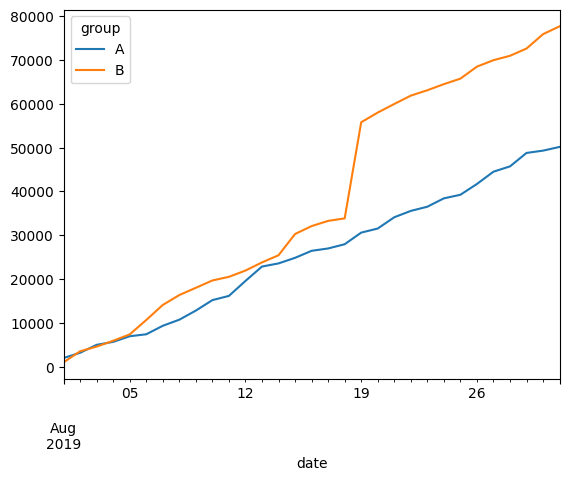

In [28]:
cumulativeData.pivot_table(
    index='date',
    columns= 'group',
    values= 'revenue'  

).plot(kind='line')


En este gráfrico podemos observar que el acumulado del grupo B aumenta considerablemente apartir del día 5, y se mantiene sobre el grupo A, por lo que en este gráfico podríamos considerar que el grupo B es mejor que el A, sin embargo, no vamos a dejarnos llevar por esta primera impresión y seguiremos analizando mas metricas. 

### Representa gráficamente el tamaño de pedido promedio acumulado por grupo. Haz conclusiones y conjeturas.

In [29]:
#Creamos una columna con el tamaño promedio de los pedidos dividiendo el acumulado de revenue entre el numero de compradores en cada día
cumulativeData['avg_revenue']=  cumulativeData['revenue'] / cumulativeData['buyers']
cumulativeData.head()

,date,group,orders,buyers,revenue,visits,avg_revenue
0,2019-08-01,A,19,19,1950.0,719,102.631579
1,2019-08-01,B,17,17,967.2,713,56.894118
2,2019-08-02,A,36,36,3148.1,1338,87.447222
3,2019-08-02,B,39,39,3490.0,1294,89.487179
4,2019-08-03,A,60,60,4963.3,1845,82.721667


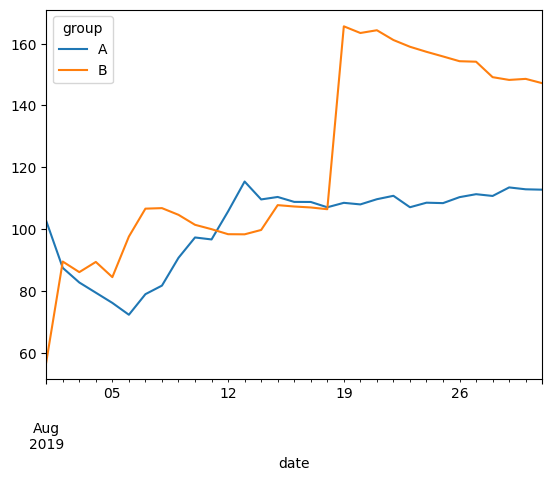

In [30]:
daily_avg_revenue = cumulativeData.pivot_table(
    index='date',
    columns='group',
    values='avg_revenue'
).plot(kind='line')

En este segundo grafico, a diferencia del primero, podemos obsevar que le tomo hasta el día 19 mantener un promedio por pedido mayor al grupo, sin embargo, después de ese día los valores se mantuvieron. Por lo que podemos considerar que el grupo B ha resultado mejor que el grupo A.

### Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. Haz conclusiones y conjeturas.

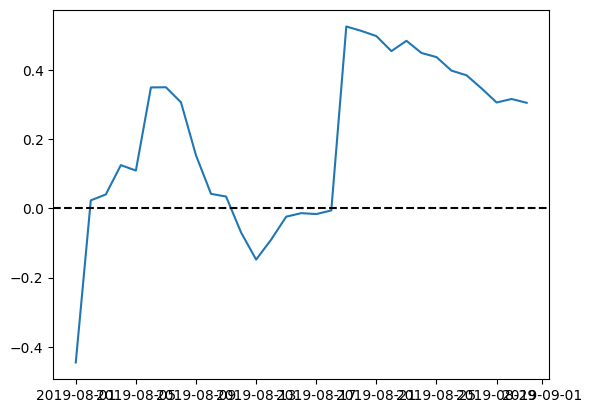

In [31]:

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# reunir los datos en un DataFrame
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB,
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['A', 'B']
)
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# agregar el eje X
plt.axhline(y=0, color='black', linestyle='--')

Podemos observar que tenemos varios valores que aumentan por encima de la línea, esto quiere decir, que tenemos pedidos grandes y probablemente valores atipicos que estan sesgando nuestro estudio. Y tambien podemos obsevar que justamente cae sobre los dias que tenemos un aumento considerable en B. Sin embargo, tambien muestra que el grupo B a comparación del A existen una diferencia entre los resultados obtenidos

### Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia. Saca conclusiones y haz conjeturas.


In [32]:
cumulativeData.columns

Index(['date', 'group', 'orders', 'buyers', 'revenue', 'visits',
       'avg_revenue'],
      dtype='object')

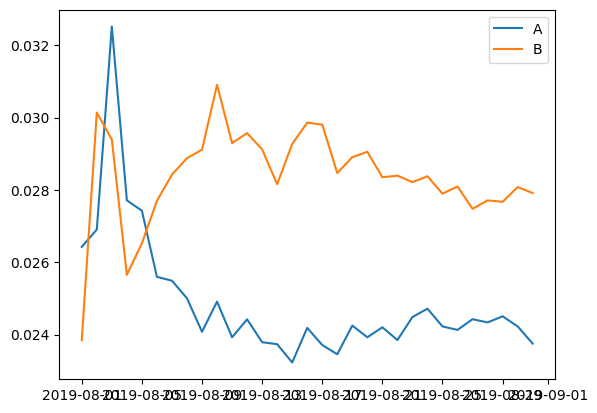

In [33]:
cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visits']
)
# seleccionar datos en el grupo A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# seleccionar datos en el grupo B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# trazar los gráficos
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()



In [34]:
cumulativeDataA.describe()
print(cumulativeDataA['date'].max())
print(cumulativeDataA['date'].min())

2019-08-31 00:00:00
2019-08-01 00:00:00


No handles with labels found to put in legend.


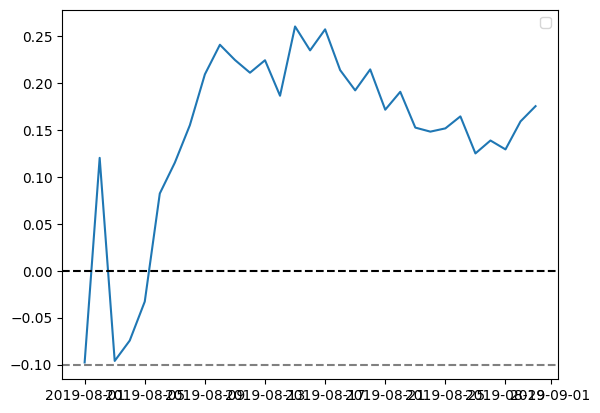

In [35]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

###  Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas.

In [36]:
orders.columns

Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

In [37]:
#creamos una tabla con los valores de 
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


(array([937.,  64.,  17.,   3.,   6.,   0.,   0.,   1.,   1.,   2.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

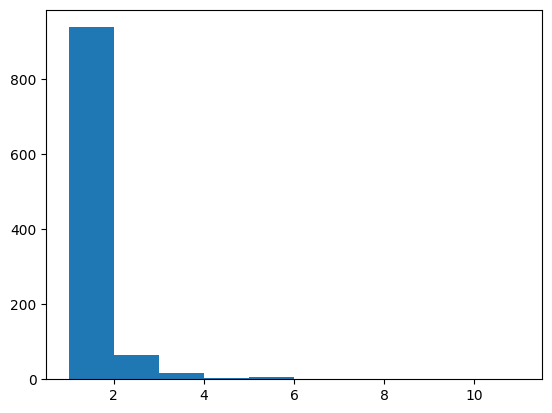

In [38]:
#creamos un histograma del número de ordenes.
plt.hist(ordersByUsers['orders'])

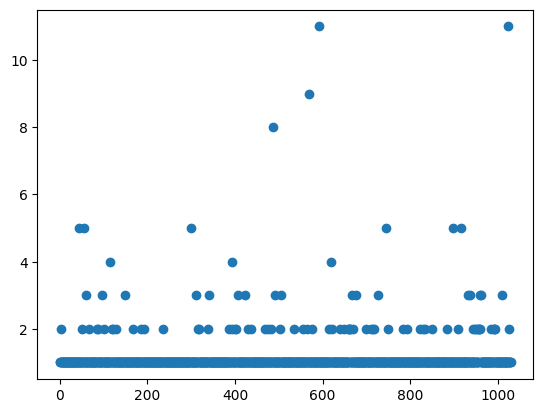

In [39]:
#creamos un grafico de dispersion
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

En este gráfico de dispersión podemos observar que la mayor parte de los usuarios realiza un solo pedido, y en alugnos casos 2 pedidos, y los usuarios que realizan mas de 3 pedidos son extraños y por lo tanto pueden considerarse atipicos. 

### Calcula los percentiles 95 y 99 para el número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.


In [40]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Podemos concluir que los valores en 1% de los valores que son mayores a 4 pedidos por usuario son anomalos ya que superan 

### Traza un gráfico de dispersión de los precios de los pedidos. Haz conclusiones y conjeturas.

In [41]:
#creamos una tabla con los valores de los precios por pedido
ordersByRevenue = (
    orders.drop(['group', 'visitorId', 'date'], axis=1)
    .groupby('transactionId', as_index=False)
    .agg({'revenue': 'sum' })
)

ordersByRevenue.columns = ['orders', 'revenue']

print(ordersByRevenue.sort_values(by='revenue', ascending=False).head(10))

          orders  revenue
168    590470918  19920.4
1107  3936777065   3120.1
49     192721366   1450.2
188    666610489   1425.8
1029  3668308183   1335.6
503   1811671147   1220.2
322   1216533772   1220.2
1000  3603576309   1050.0
364   1348774318   1025.8
81     316924019   1015.9


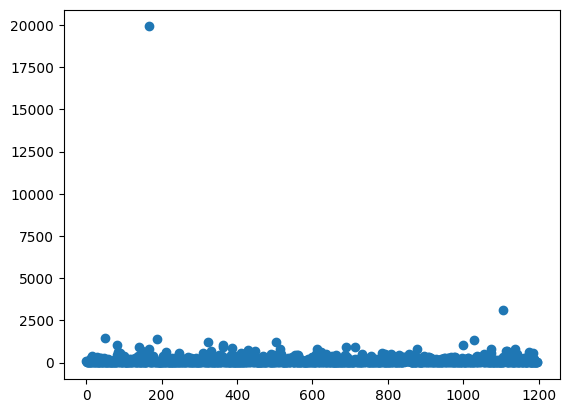

In [42]:
x_values = pd.Series(range(0,len(ordersByRevenue)))

plt.scatter(x_values, ordersByRevenue['revenue'])

### Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [43]:
print(np.percentile(ordersByRevenue['revenue'], [95, 99]))

[435.54  900.904]


<AxesSubplot:title={'center':'revenue'}, xlabel='group'>

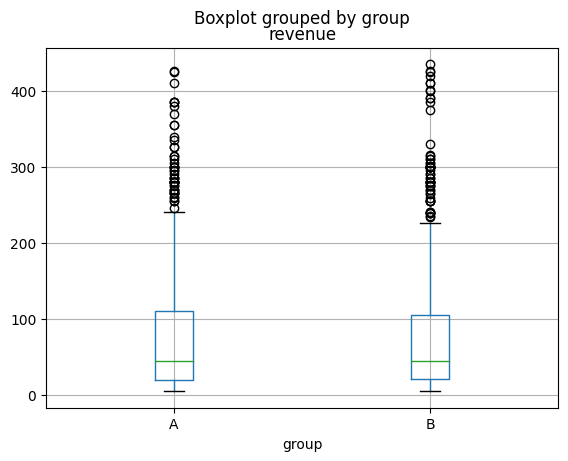

In [44]:
orders[orders['revenue'] < 435.54].boxplot(by='group', column='revenue')

Con el gráfico de caja podemos observar que el 5% de nuestros datos se encuentran fuera de Q2 lo cual significa que son anomalos y puden provocar un sesgo en nuestro análisis. 

### Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [45]:
#se crean variables para cada grupo
ordersByUsersA = clean_orders[clean_orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = clean_orders[clean_orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

In [46]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [47]:
#Pvalue
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
#Diferencia de grupos
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.011
0.175


Podemos rechazar la hipótesis nula ya que hay una diferencia estadísticamente significativa en la conversión entre los grupos, ya que el valor de Pvalue arrojado es menor a 0.05.

### Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.

In [48]:
#Se calcula la diferencia en el tamaño promedio de pedido
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
#La diferencia entre el grupo B y el grupo A
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.692
0.252


El valor p es notablemente superior a 0.05 por lo que no hay motivo para rechazar la hipótesis nula y concluir que el tamaño medio de los pedidos difiere entre los grupos. 
Por otro lado, tambien nos arroja que el valor promedio del grupo B es mucho mayor que A.

### Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.


In [49]:
#Se crea la variable usersWithManyOrders para almacenar los usuarios con muchas ordenes considerando como anomalo a los valores fuera del 95%
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis = 0)
usersWithExpensiveOrders = clean_orders[clean_orders['revenue'] > 435.64]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
928     204675465
684     358944393
648     382846391
751     689129267
Name: visitorId, dtype: int64
(47,)


Contamos con 47 usuarios anomalos

In [50]:
#Se crea una muestra con los datos filtrados para el grupo A como para el grupo B

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)


In [51]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.014
0.173


Con los datos filtrados obtenemos que el pvalue aumento, sin embargo, es menor que 0.05 por lo cual la hipotesis se continua rechazando.
La diferencia apenas y cambio de 17.5% a 17.3%
Por lo que podemos concluir que existe una diferencia significativa en la diferencia de la conversion entre los grupos.

### Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.

In [54]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    clean_orders[np.logical_and(
        clean_orders['group']=='A',
        np.logical_not(clean_orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    clean_orders[np.logical_and(
        clean_orders['group']=='B',
        np.logical_not(clean_orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('{0:.3f}'.format(
    clean_orders[np.logical_and(clean_orders['group']=='B',np.logical_not(clean_orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    clean_orders[np.logical_and(
        clean_orders['group']=='A',
        np.logical_not(clean_orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.800
-0.030


En este caso el Pvalue de la diferencia en el tamaño promedio de los pedidos se continua aceptando nuestra hipotesis, sin embargo, la diferencia se redujo del 25% a solo el 3% de diferencia entre los dos grupos.

### Toma una decisión basada en los resultados de la prueba. Las decisiones posibles son: 1. Para la prueba, considera a uno de los grupos como líder. 2. Para la prueba, concluye que no hay diferencia entre los grupos. 3. Continúa la prueba.

Con la información que obtuvimos durante este análisis podemos concluir que el grupo B tiene una mejor conversión que el grupo A, por otro lado, con los datos obtenidos solo obtuvimos una diferencia del 3% en el tamaño promedio de pedido. Por lo que podemos concluir, que el grupo B es mejor que el grupo A, con este resultado podriamos detener la prueba, sin embargo, seria interesante observar la evolución del tamaño promedio de pedido entre grupos y obsevar el comportamiento de esa diferencia. Si aumenta o disminuye.